In [1]:
import os 
import sys

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table
import pandas as pd
import scipy.signal as signal

sys.path.append("/home/jovyan/experience-analysis-of-grb-emission-mmlab02")

In [2]:
#vediamo quali detector hanno avuto un segnale di trigger
detected=[]
main_dir =os.getcwd()
data_dir = os.path.join(main_dir,"data/current")
results_dir = os.path.join(main_dir, 'results')

file_tcat = 'glg_trigdat_all_bn090926181_v01.fit'
input_filename_tcat = os.path.join(data_dir, file_tcat)
fits_info_tcat = fits.open(input_filename_tcat)
print('Trig data file')
fits_info_tcat.info() # there is 1 HDU

header_tcat = fits_info_tcat[0].header
print("Triggered NaI detectors %s" % header_tcat['DET_MASK'])

TTE_dir=os.path.join(data_dir,'TTE')
#vediamo quali sono gli HDU di un file
file='glg_tte_n3_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
print('\nTTE example file')
fits_info.info() #there are 4 HDUs 

header = fits_info[2].header
print('\n HDU 2 header')
print(f'Total number of channels in each rate = %s' % header["DETCHANS"])
header

Trig data file
Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/glg_trigdat_all_bn090926181_v01.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      49   ()      
  1  TRIGRATE      1 BinTableHDU     48   1R x 5C   [1D, 1D, 4E, 3E, 112E]   
  2  BCKRATES      1 BinTableHDU     46   1R x 4C   [1D, 1D, 2B, 112E]   
  3  OB_CALC       1 BinTableHDU     74   2R x 15C   [1D, 1E, 1E, 1E, 1I, 2I, 2E, 1E, 1E, 1E, 1E, 12I, 1E, 1E, 1E]   
  4  MAXRATES      1 BinTableHDU     49   2R x 5C   [1D, 1D, 4E, 3E, 112E]   
  5  EVNTRATE      1 BinTableHDU     49   153R x 5C   [1D, 1D, 4E, 3E, 112E]   
Triggered NaI detectors 000100010000

TTE example file
Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/TTE/glg_tte_n3_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   10 / width of table in bytes                        
NAXIS2  =               436328 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TZERO1  =     275631628.986532 / Offset, equal to TRIGTIME                      
TTYPE2  = 'PHA     '        

## NAI DETECTORS

In [ ]:
# file TTE contiene i dati dell'osservazione [time tagged event]
files = sorted(os.listdir(TTE_dir))
NAI_files=[]
for file in files:
    if "glg_tte_n" in file: #selecting NAI detectors
        NAI_files=np.append(NAI_files, file) 
        
acceptance=5 #-> 3 soft acceptance, 5 hard acceptance

ii=0
for file in NAI_files:
    input_filename = os.path.join(TTE_dir,file)
    fits_info = fits.open(input_filename) # opening header
    header = fits_info[2].header
    data=fits.getdata(input_filename, ext=2) # open file fits
    n = Table(data)
    dfn= n.to_pandas() # create pandas data frame
    t=dfn['TIME']
    
    dt= t- np.min(t) #time from start of observation

    #light curve
    plt.figure(figsize=(12,6))
    plt.title('Light curve n %d' %(ii), fontsize=15)
    plt.xlabel('Time since T0 [s]', fontsize=15)
    plt.ylabel('Counts/Bin ', fontsize=15)
    bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
    plt.ylim([0,np.max(bin_heights)+200])
    ii+=1
    
    # selecting window for computing background
    window_beginning=200
    window_ending=300
    start = bin_counts>window_beginning 
    stop = bin_counts<window_ending
    mask_dt = np.logical_and(start, stop)

    bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
    err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]]) # background error
    print('bg %f \pm %f' %(bg,err_bg))

    mask_event=bin_heights>acceptance*err_bg+bg

    if len(bin_heights[mask_event])!=0:
        print('This file %d contains an event!' %(ii))
        detected=np.append(detected,file)
    else:
        print('This file %d does NOT contain an event:' %(ii))

**GRB CLASS:**

-nome

-start obs e stop obs

-detector trigger

-detector con segnale?


Nonostante solo il 4 e 8 detector diano il trigger per il segnale, tutti quanti osservano il burst, perche' la dev. stand. del background e' sufficientemente bassa da registrare un segnale in ogni NaI detector.

Gli NaI che hanno visualizzato per primi sono quelli che erano orientati meglio e che hanno piu' conteggi.

## BGO detectors

In [ ]:
#apriamo i TTE files
BG0_files=[]
for file in files:
    if "glg_tte_b" in file: #selecting BGO detectors
        BG0_files=np.append(BG0_files, file) 

ii=0
for file in BG0_files:
    input_filename = os.path.join(TTE_dir,file)
    data=fits.getdata(input_filename, ext=2)
    n = Table(data)
    dfn= n.to_pandas()
    
    t=dfn['TIME']
    dt= t- np.min(t) #time from start of observation
    
    #light curve
    plt.figure(figsize=(12,6))
    plt.title('Light curve b %d' %(ii), fontsize=15)
    plt.xlabel('Time since T0 [s]', fontsize=15)
    plt.ylabel('Counts/Bin ', fontsize=15)
    bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
    plt.ylim([0,np.max(bin_heights)+1000])
    ii+=1
    
    window_beginning=200
    window_ending=300
    start = bin_counts>window_beginning 
    stop = bin_counts<window_ending
    mask_dt = np.logical_and(start, stop)

    bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
    err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]])
    print('bg %f \pm %f' %(bg,err_bg))

    mask_event=bin_heights>acceptance*err_bg+bg

    if len(bin_heights[mask_event])!=0:
        print('This file %d contains an event!' %(ii))
        detected=np.append(detected,file)
    else:
        print('This file %d does NOT contain an event:' %(ii))

In [ ]:
pat=[] #photon arrival time 
for file in detected:
    input_filename = os.path.join(TTE_dir,file)
    data=fits.getdata(input_filename, ext=2)
    n = Table(data)
    dfn= n.to_pandas()
    
    t=dfn['TIME']
    dt= t- np.min(t) #time from start of observation
    pat=np.append(pat,dt)

#light curve
plt.figure(figsize=(12,6))
plt.title('Cumulative light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)

hist, bins=np.histogram(pat,bins=1500)
plt.hist(pat,bins=bins)
plt.ylim([0,np.max(hist)+1000])

In [ ]:
window_beginning=200
window_ending=300
start = bins>window_beginning 
stop = bins<window_ending
mask_dt = np.logical_and(start, stop)

bg=np.mean(hist[mask_dt[:len(mask_dt)-1]]) #background dell'istogramma cumulativo
err_bg=np.std(hist[mask_dt[:len(mask_dt)-1]])
print('bg %f \pm %f' %(bg,err_bg))

#light curve  (soft acceptance)
adj_hist=hist-bg
mask_event=hist>3*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)

plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.17, facecolor='darkorange', alpha=0.1, label='Noise')
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.3, 1, facecolor='darkorange', alpha=0.1)
plt.text(164, np.max(adj_hist[mask_event])-2000,'acceptance=3$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.legend(loc=(0.85,0.9), fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+100])

#light curve (hard acceptance)
adj_hist=hist-bg
mask_event=hist>acceptance*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+200])
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.07, facecolor='darkorange', alpha=0.1, label='Noise')
plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.47, 1, facecolor='darkorange', alpha=0.1)
plt.text(55.5, np.max(adj_hist[mask_event])-2000,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.legend(loc='best', fontsize=15)

### Computing T90

In [ ]:
# the background has been subtracted from the cumulative histogram, che T90 can be computes as the time interval 
# between 5% of the total number of photons and the 95% (above noise which is absent in our plot)

times = bins[:-1][mask_event]
mask_phot= adj_hist[mask_event]
photons_tot = np.sum(mask_phot) 
print('total counts above background = %f' % photons_tot)
start_count=photons_tot*5/100
stop_count=photons_tot*95/100
print('five percent of counts = %f' %start_count)
print('ninety five percent of counts = %f' %stop_count)

dt = max(bins)/1500
print('Bin width = %f' % dt)

# cerco di trovare il punto dove ho il 5% di conteggi
for ii in range(len(mask_phot)):
    somma=np.sum(mask_phot[:ii])
    cond1=somma<start_count+1000
    cond2=somma>start_count-1000
    cond=np.logical_and(cond1,cond2)
    if cond==True:
        print('Found start')
        print(somma)
        print('array index= %d' %ii)
        start_time = times[ii]
        print('start time= %f' % start_time)
        print('start counts = %f' % mask_phot[ii])
        start_error = np.sqrt(mask_phot[ii])
        print('start counts error = %f' % start_error)

        err_start = abs(start_count - somma) / photons_tot * max(times) 

# cerco di trovare il punto dove ho il 95% di conteggi
for jj in range(len(mask_phot)):
    somma=np.sum(mask_phot[:jj])
    cond1=somma<stop_count+500
    cond2=somma>stop_count-500
    cond=np.logical_and(cond1,cond2)
    if cond==True:
        print('Found stop')
        print(somma)
        print('array index= %d' %ii)
        stop_time = times[jj]
        print('stop time= %f' % stop_time)
        print('stop counts = %f' % mask_phot[jj])
        stop_error = np.sqrt(mask_phot[jj])
        print('stop counts error = %f' % stop_error)
        
        err_stop = abs(stop_count - somma) / photons_tot * max(times)

# errore massimo
print('start time error = %f ' % err_start)
print('stop time error = %f ' % err_stop)

err_tot_start = np.sqrt(err_start**2 + dt**2)
err_tot_stop = np.sqrt(err_stop**2 + dt**2)
print('err_tot_start = %f' % err_tot_start)
print('err_tot_stop = %f' % err_tot_stop)
        
# errore """"statistico""""
err_start = start_error / photons_tot * max(times) 
err_stop = stop_error / photons_tot * max(times)
print('start time error = %f ' % err_start)
print('stop time error = %f ' % err_stop)



t_90 = stop_time - start_time
print('T90 is %.2f +/- %.2f s' % (t_90, np.sqrt(2)*dt)) # long grb 

In [ ]:
#light curve (hard acceptance) with T90
adj_hist=hist-bg
mask_event=hist>acceptance*err_bg+bg

plt.figure(figsize=(12,6))
plt.bar(bins[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.ylim([0,np.max(adj_hist[mask_event])+200])
#plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0, 0.07, facecolor='darkorange', alpha=0.1, label='Noise')
#plt.axhspan(0, np.max(adj_hist[mask_event])+100, 0.52, 1, facecolor='darkorange', alpha=0.1)
plt.text(55.5, np.max(adj_hist[mask_event])-2500,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))
plt.axvline(x=start_time, linestyle='dashed', color='orange', label='5% of counts')
plt.axvline(x=stop_time, linestyle='dashed', color='red', label='95% of counts')
plt.legend(loc='best', fontsize=12)
plot_name = 'GRB_lightcurve.pdf'
plt.savefig(os.path.join(results_dir, plot_name), bbox_inches='tight')

### Light curves for energy bands NaI detectors

In [8]:
file='glg_tte_n3_bn090926181_v00.fit' # choosing file
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename) # opening file
fits_info.info() #there are 4 HDUs 

header = fits_info[1].header # le energie sono espresse in kev
data_en = fits.getdata(input_filename, ext=1) 
energy_bounds = Table(data_en)
df = energy_bounds.to_pandas() # creating data frame for energies
channel = df['CHANNEL']
e_min = df['E_MIN']
e_max = df['E_MAX']

# for NaI 15-260 KeV 
cond1=e_min>15
cond2=e_max<260
mask = cond1 & cond2
wanted_channels=channel[mask]
df

Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/TTE/glg_tte_n3_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   436328R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   
455.45023
468.50504


,TIME,PHA
0,2.756316e+08,34
1,2.756316e+08,14
2,2.756316e+08,11
3,2.756316e+08,34
4,2.756316e+08,30
...,...,...
436323,2.756319e+08,127
436324,2.756319e+08,14
436325,2.756319e+08,12
436326,2.756319e+08,31


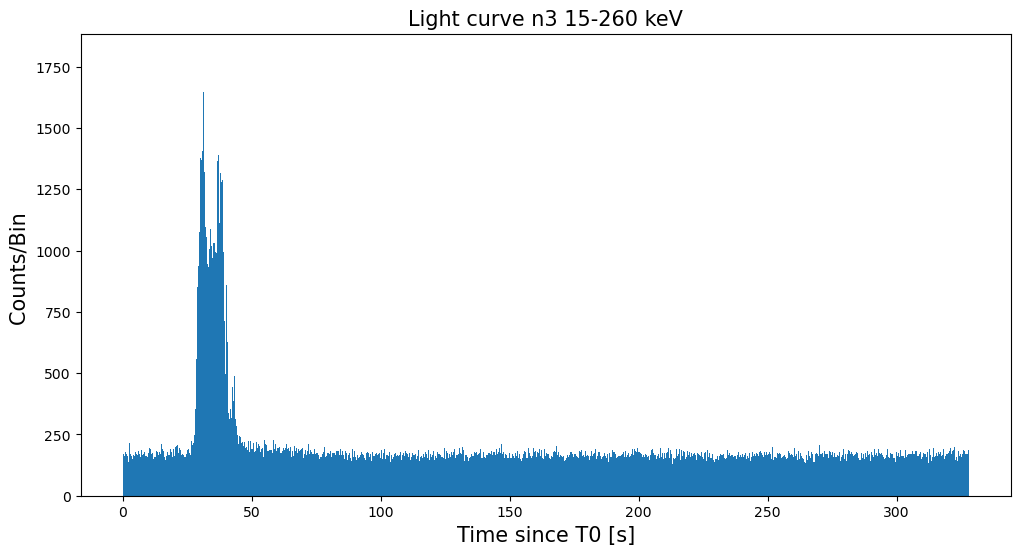

In [5]:
data_counts = fits.getdata(input_filename, ext=2) # getting time of arrival of photons
counts = Table(data_counts)
df_c = counts.to_pandas() # creating data frame for times
pha = df_c['PHA']
time = df_c['TIME']

mask_pha = pha.isin(wanted_channels) # selecting only the channels I want
selected_time = time[mask_pha] # selecting corresponding times

dt= selected_time.array- np.min(selected_time.array) #time from start of observation

#plotting light curve

plt.figure(figsize=(12,6))
plt.title('Light curve n3 15-260 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights)+200])

bg 165.174672 \pm 13.046610


Text(46, 1449.825327510917, 'acceptance=5$\\sigma$')

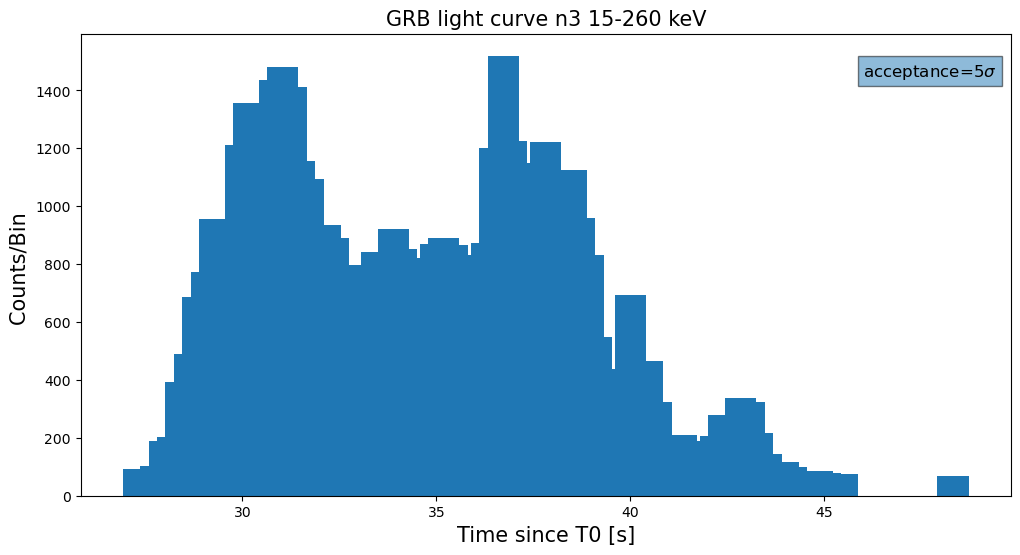

In [6]:
# selecting window for computing background
window_beginning=200
window_ending=300
start = bin_counts>window_beginning 
stop = bin_counts<window_ending
acceptance = 5

mask_dt = np.logical_and(start, stop)
bg=np.mean(bin_heights[mask_dt[:len(mask_dt)-1]]) #background
err_bg=np.std(bin_heights[mask_dt[:len(mask_dt)-1]]) # background error
print('bg %f \pm %f' %(bg,err_bg))

mask_event=bin_heights>acceptance*err_bg+bg # selecting counts above background
adj_hist=bin_heights-bg

# plotting light curve
fig1 = plt.figure(figsize=(12,6))
plt.bar(bin_counts[:-1][mask_event],adj_hist[mask_event])
plt.title('GRB light curve n3 15-260 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.text(46, np.max(adj_hist[mask_event])-70,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))

(0.0, 160.0)

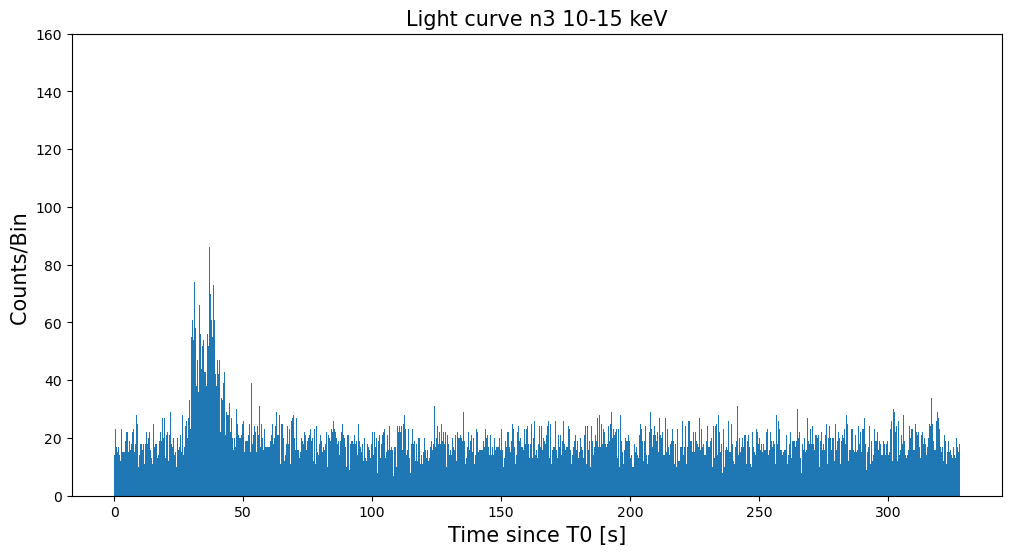

In [11]:
# for NaI 10-15 keV
cond1=e_min>10
cond2=e_max<15
mask = cond1 & cond2
wanted_channels=channel[mask]

# selection
mask_pha = pha.isin(wanted_channels) # selecting only the channels I want
selected_time = time[mask_pha] # selecting corresponding times

dt= selected_time.array- np.min(selected_time.array) #time from start of observation

#plotting light curve

plt.figure(figsize=(12,6))
plt.title('Light curve n3 10-15 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights2, bin_counts2,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights2)+50])

bg 18.242888 \pm 4.396647


Text(41, 81.75711159737418, 'acceptance=5$\\sigma$')

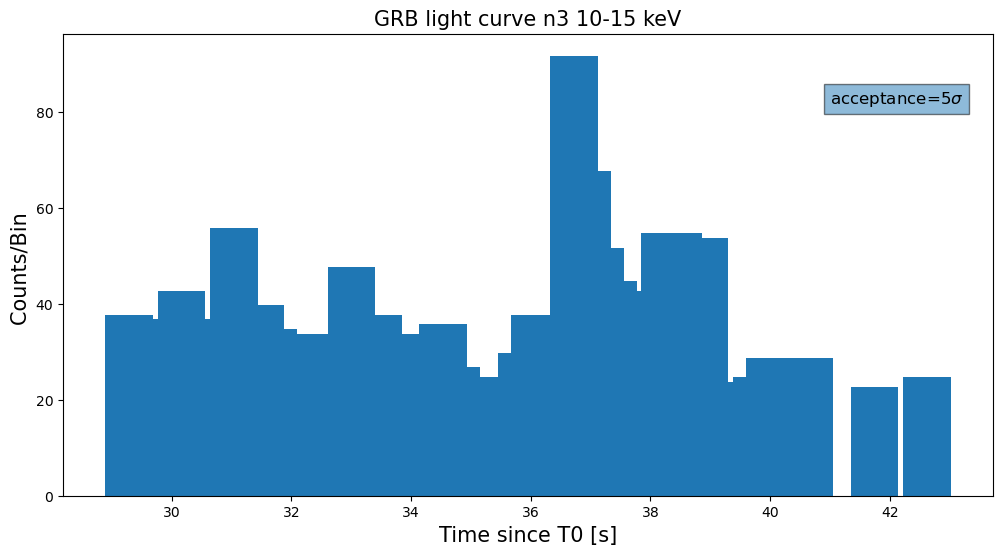

In [14]:
# selecting window for computing background
window_beginning=200
window_ending=300
start = bin_counts2>window_beginning 
stop = bin_counts2<window_ending
acceptance = 5

mask_dt = np.logical_and(start, stop)
bg=np.mean(bin_heights2[mask_dt[:len(mask_dt)-1]]) #background
err_bg=np.std(bin_heights2[mask_dt[:len(mask_dt)-1]]) # background error
print('bg %f \pm %f' %(bg,err_bg))

mask_event2=bin_heights2>acceptance*err_bg+bg # selecting counts above background
adj_hist2=bin_heights2-bg

# plotting light curve
fig2 = plt.figure(figsize=(12,6))
plt.bar(bin_counts2[:-1][mask_event2],adj_hist2[mask_event2])
plt.title('GRB light curve n3 10-15 keV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.text(41, np.max(adj_hist2[mask_event])-10,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))

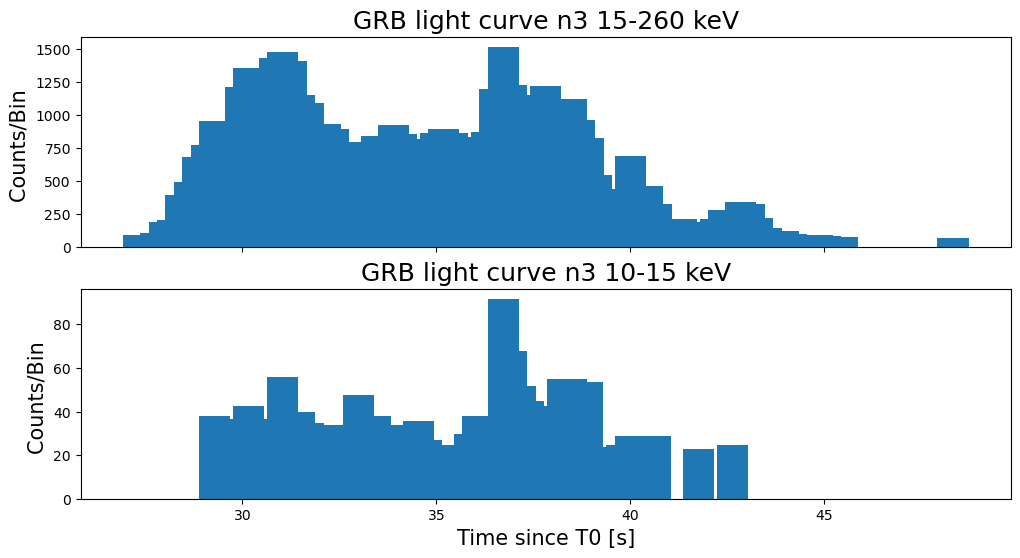

In [16]:
# creating the subplots
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax_top.bar(bin_counts[:-1][mask_event],adj_hist[mask_event])
ax_bottom.bar(bin_counts2[:-1][mask_event2],adj_hist2[mask_event2])
ax_top.set_title('GRB light curve n3 15-260 keV', fontsize=18)
ax_bottom.set_title('GRB light curve n3 10-15 keV', fontsize=18)
plt.xlabel('Time since T0 [s]', fontsize=15)
ax_top.set_ylabel('Counts/Bin ', fontsize=15)
ax_bottom.set_ylabel('Counts/Bin ', fontsize=15)

plot_name = 'GRB_lightcurve_n3.pdf'
plt.savefig(os.path.join(results_dir, plot_name), bbox_inches='tight')

### Light curves energy bands for BGO detectors

In [10]:
file='glg_tte_b0_bn090926181_v00.fit' # choosing file
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename) # opening file
fits_info.info() #there are 4 HDUs 

header = fits_info[1].header # le energie sono espresse in kev
data_en = fits.getdata(input_filename, ext=1) 
energy_bounds = Table(data_en)
df = energy_bounds.to_pandas() # creating data frame for energies
channel = df['CHANNEL']
e_min = df['E_MIN']
e_max = df['E_MAX']

# for BGO 260 keV - 5 MeV
cond1=e_min>260
cond2=e_max<5000
mask = cond1 & cond2
wanted_channels=channel[mask]
print(e_min[5])
print(e_max[5])

Filename: /home/jovyan/experience-analysis-of-grb-emission-mmlab02/data/current/TTE/glg_tte_b0_bn090926181_v00.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  EBOUNDS       1 BinTableHDU     58   128R x 3C   [1I, 1E, 1E]   
  2  EVENTS        1 BinTableHDU     48   977520R x 2C   [1D, 1I]   
  3  GTI           1 BinTableHDU     44   1R x 2C   [1D, 1D]   
351.87964
385.25745


(0.0, 1261.0)

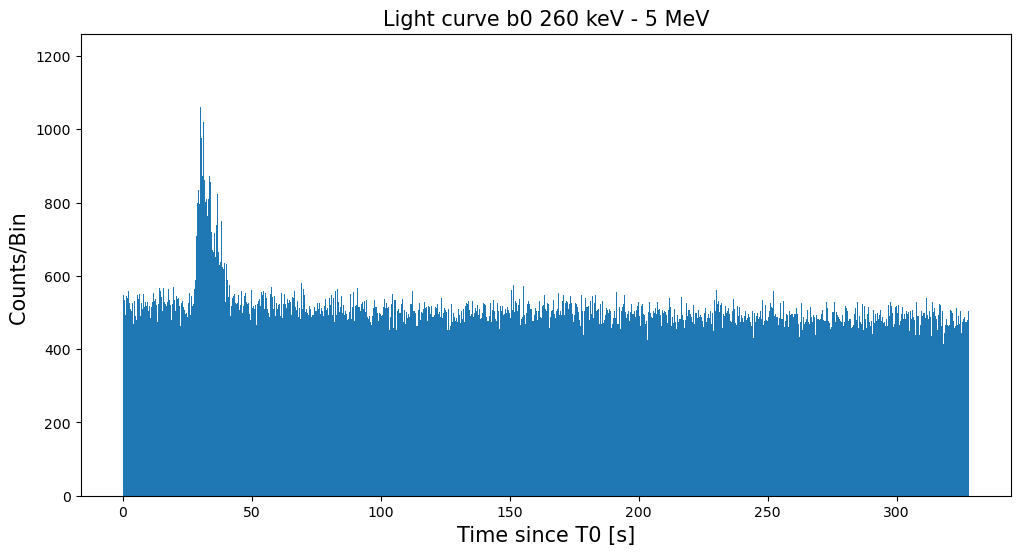

In [19]:
data_counts = fits.getdata(input_filename, ext=2) # getting time of arrival of photons
counts = Table(data_counts)
df_c = counts.to_pandas() # creating data frame for times
pha = df_c['PHA']
time = df_c['TIME']

mask_pha = pha.isin(wanted_channels) # selecting only the channels I want
selected_time = time[mask_pha] # selecting corresponding times

dt= selected_time.array- np.min(selected_time.array) #time from start of observation

#plotting light curve

plt.figure(figsize=(12,6))
plt.title('Light curve b0 260 keV - 5 MeV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights3, bin_counts3,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights3)+200])

bg 491.657205 \pm 22.353413


Text(38.5, 519.3427947598253, 'acceptance=5$\\sigma$')

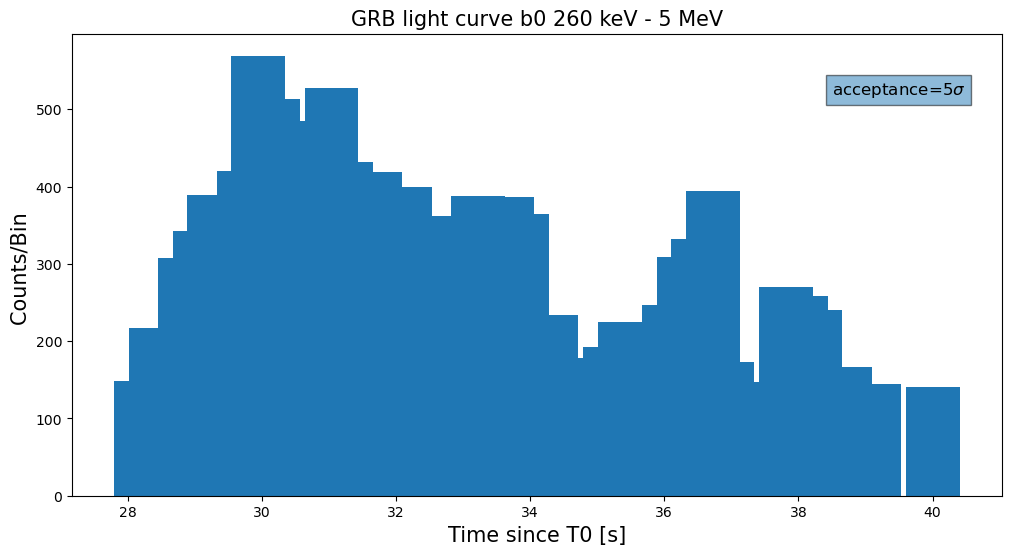

In [20]:
# selecting window for computing background
window_beginning=200
window_ending=300
start = bin_counts3>window_beginning 
stop = bin_counts3<window_ending
acceptance = 5

mask_dt = np.logical_and(start, stop)
bg=np.mean(bin_heights3[mask_dt[:len(mask_dt)-1]]) #background
err_bg=np.std(bin_heights3[mask_dt[:len(mask_dt)-1]]) # background error
print('bg %f \pm %f' %(bg,err_bg))

mask_event3=bin_heights3>acceptance*err_bg+bg # selecting counts above background
adj_hist3=bin_heights3-bg

# plotting light curve
fig1 = plt.figure(figsize=(12,6))
plt.bar(bin_counts3[:-1][mask_event3],adj_hist3[mask_event3])
plt.title('GRB light curve b0 260 keV - 5 MeV', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
plt.text(38.5, np.max(adj_hist3[mask_event])-50,'acceptance=5$\sigma$', fontsize=12,bbox=dict(alpha=0.5))

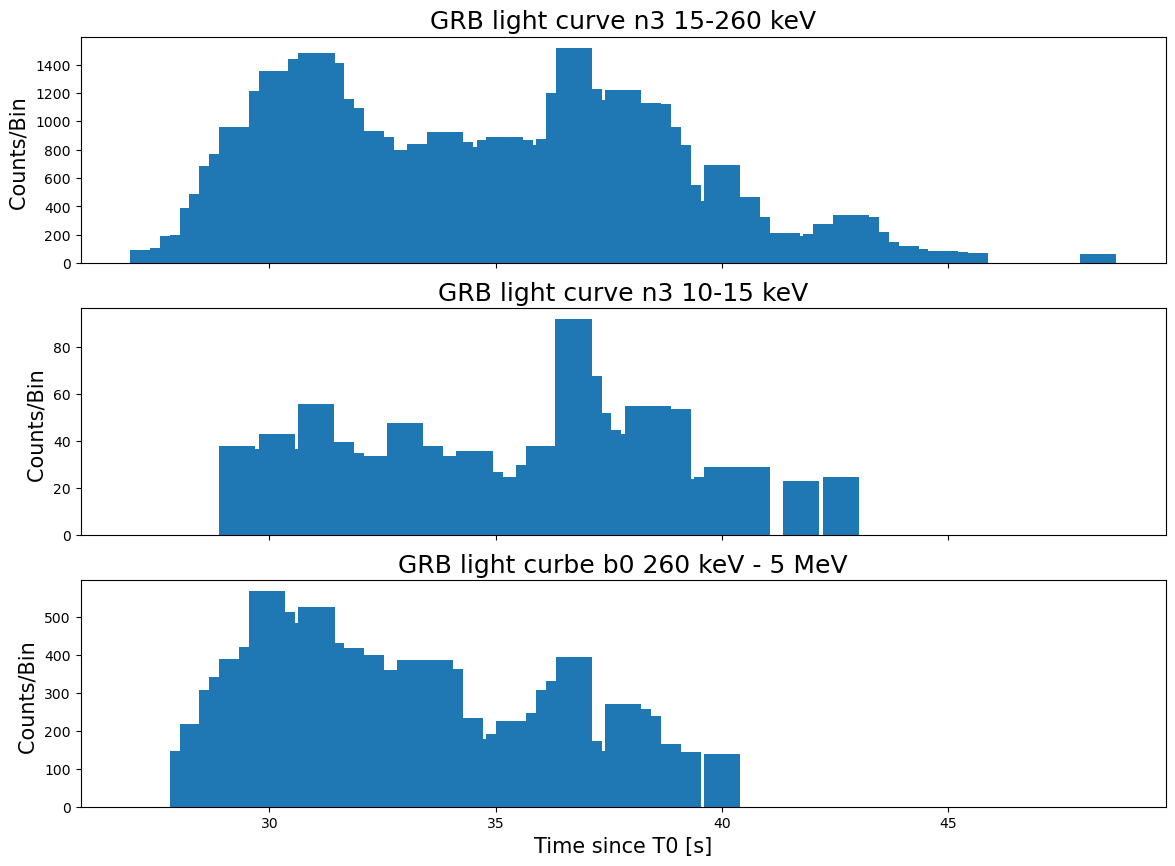

In [22]:
# creating the subplots
fig, (ax_top, ax_bottom, ax_medium) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

ax_top.bar(bin_counts[:-1][mask_event],adj_hist[mask_event])
ax_bottom.bar(bin_counts2[:-1][mask_event2],adj_hist2[mask_event2])
ax_medium.bar(bin_counts3[:-1][mask_event3],adj_hist3[mask_event3])

ax_top.set_title('GRB light curve n3 15-260 keV', fontsize=18)
ax_bottom.set_title('GRB light curve n3 10-15 keV', fontsize=18)
ax_medium.set_title('GRB light curbe b0 260 keV - 5 MeV', fontsize=18)

plt.xlabel('Time since T0 [s]', fontsize=15)
ax_top.set_ylabel('Counts/Bin ', fontsize=15)
ax_bottom.set_ylabel('Counts/Bin ', fontsize=15)
ax_medium.set_ylabel('Counts/Bin ', fontsize=15)

plot_name = 'GRB_lightcurve_all.pdf'
plt.savefig(os.path.join(results_dir, plot_name), bbox_inches='tight')

### Individuazione picchi curva di luce

In [ ]:
file='glg_tte_b0_bn090926181_v00.fit'
input_filename = os.path.join(TTE_dir,file)
fits_info= fits.open(input_filename)
fits_info.info() #there are 4 HDUs 

data_counts = fits.getdata(input_filename, ext=2) 
counts = Table(data_counts)
df_c = counts.to_pandas()
time = df_c['TIME']

dt = time - np.min(time)
plot=plt.figure(figsize=(12,6))
plt.title('Light curve b0', fontsize=15)
plt.xlabel('Time since T0 [s]', fontsize=15)
plt.ylabel('Counts/Bin ', fontsize=15)
bin_heights, bin_counts,_=plt.hist(dt,bins=1500)
plt.ylim([0,np.max(bin_heights)+200])
plt.xlim([25, 50])
ax = plot.gca()

# get bin centers

bin_width = (np.max(bin_counts)-np.min(bin_counts))/1500
bin_centers = bin_counts + bin_width/2
bin_centers = bin_centers[:-1] # tolgo l'ultimo perchè è l'estremo finale
peaks,_ = signal.find_peaks(bin_heights, prominence=200) # individuo i picchi
#err = [1, 1, 0.5, 0.5, 0.5, 0.5, 0.5]
plt.errorbar(bin_centers[peaks], bin_heights[peaks], fmt='.', color='red')
print('Times of selected peaks', bin_centers[peaks])


In [18]:
''' Model Flux    7.8462 photons (3.2154e-07 ergs/cm^2/s) range (10.000 - 50.000 keV)
     Error range     7.697 - 7.962    (3.163e-07 - 3.256e-07)  (68.00% confidence)'''

shr = 0.57
a = (7.962-7.697)/2
b = a/7.8462
print(b)
print(a)
print('7.8462')
print(shr*7.8462)
print(shr*7.8462*b)

print(2*b*shr)

0.016887155565751554
0.13249999999999984
7.8462
4.472333999999999
0.0755249999999999
0.01925135734495677
